# Pierwszy sposób pobierania danych - Historical Forecast API

## Wszystko w pliku z_api_satelity.py - zapisane w pogoda_epkk_lipiec_2024.csv

In [7]:
import pandas as pd

pobieranie_api = pd.read_csv("pogoda_api_lipiec_2024.csv")

pobieranie_api.head()

,date,temperature_2m,relative_humidity_2m,wind_speed_10m
0,2024-07-04 00:00:00+00:00,14.563499,82.0,1.8
1,2024-07-04 01:00:00+00:00,13.513499,87.0,1.2
2,2024-07-04 02:00:00+00:00,13.013499,87.0,1.2
3,2024-07-04 03:00:00+00:00,13.613500,81.0,1.6
4,2024-07-04 04:00:00+00:00,14.263499,77.0,1.3


# Drugi sposób czyli realne czujniki wunder - pobieranie_wunder.csv

In [19]:
pobieranie_wunder = pd.read_csv("pobieranie_wunder.csv")

print(pobieranie_wunder.head())

                        date  temperature_2m  relative_humidity_2m  \
0  2024-07-04 23:00:00+00:00            15.0                  88.0   
1  2024-07-04 00:00:00+00:00            15.0                  88.0   
2  2024-07-04 01:00:00+00:00            15.0                  88.0   
3  2024-07-04 02:00:00+00:00            15.0                  88.0   
4  2024-07-04 03:00:00+00:00            15.0                  88.0   

   wind_speed_10m  
0             0.9  
1             0.9  
2             0.9  
3             1.3  
4             0.4  


# Analiza obu df


Statystyki różnic temperatur:
count    408.000000
mean       0.060913
std        2.106051
min       -7.564277
25%       -1.057333
50%        0.107945
75%        1.466279
max        7.374611
Name: temp_diff, dtype: float64

Statystyki różnic wilgotności:
count    408.000000
mean       0.931373
std       10.177308
min      -24.000000
25%       -6.000000
50%        0.000000
75%        6.250000
max       42.000000
Name: humidity_diff, dtype: float64

Statystyki różnic prędkości wiatru:
count    408.000000
mean      -0.292157
std        1.301421
min       -6.100000
25%       -1.000000
50%       -0.200000
75%        0.600000
max        2.500000
Name: wind_diff, dtype: float64

Korelacja temperatur: 0.88
Korelacja wilgotności: 0.82


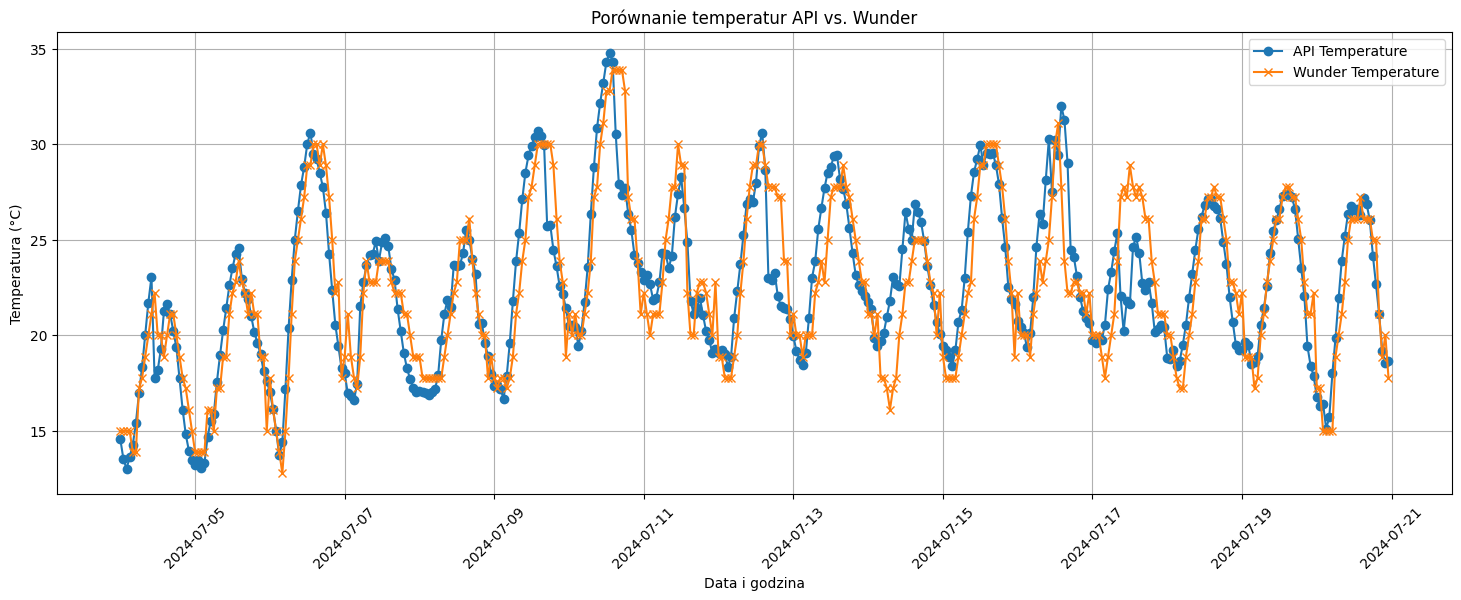

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Wczytaj dane, upewniając się, że datetime jest poprawnie parsowany
pobieranie_api = pd.read_csv("pogoda_api_lipiec_2024.csv", parse_dates=['date'])
pobieranie_wunder = pd.read_csv("pobieranie_wunder.csv", parse_dates=['date'])

# Dopasowanie tylko tych wierszy, gdzie datetime się zgadza
merged_df = pd.merge(pobieranie_api, pobieranie_wunder, on='date', suffixes=('_api', '_wunder'))

# Oblicz różnice dla każdej zmiennej
merged_df['temp_diff'] = merged_df['temperature_2m_api'] - merged_df['temperature_2m_wunder']
merged_df['humidity_diff'] = merged_df['relative_humidity_2m_api'] - merged_df['relative_humidity_2m_wunder']
merged_df['wind_diff'] = merged_df['wind_speed_10m_api'] - merged_df['wind_speed_10m_wunder']

# Wyświetlenie statystyk różnic
print("\nStatystyki różnic temperatur:")
print(merged_df['temp_diff'].describe())

print("\nStatystyki różnic wilgotności:")
print(merged_df['humidity_diff'].describe())

print("\nStatystyki różnic prędkości wiatru:")
print(merged_df['wind_diff'].describe())

# Korelacje między danymi z API i Wunder
corr_temp = merged_df[['temperature_2m_api', 'temperature_2m_wunder']].corr().iloc[0, 1]
corr_humidity = merged_df[['relative_humidity_2m_api', 'relative_humidity_2m_wunder']].corr().iloc[0, 1]

print(f"\nKorelacja temperatur: {corr_temp:.2f}")
print(f"Korelacja wilgotności: {corr_humidity:.2f}")

# Wykres porównania temperatur
plt.figure(figsize=(18, 6))
plt.plot(merged_df['date'], merged_df['temperature_2m_api'], label='API Temperature', marker='o')
plt.plot(merged_df['date'], merged_df['temperature_2m_wunder'], label='Wunder Temperature', marker='x')
plt.xlabel("Data i godzina")
plt.ylabel("Temperatura (°C)")
plt.legend()
plt.title("Porównanie temperatur API vs. Wunder")
plt.xticks(rotation=45)
plt.grid()
plt.show()

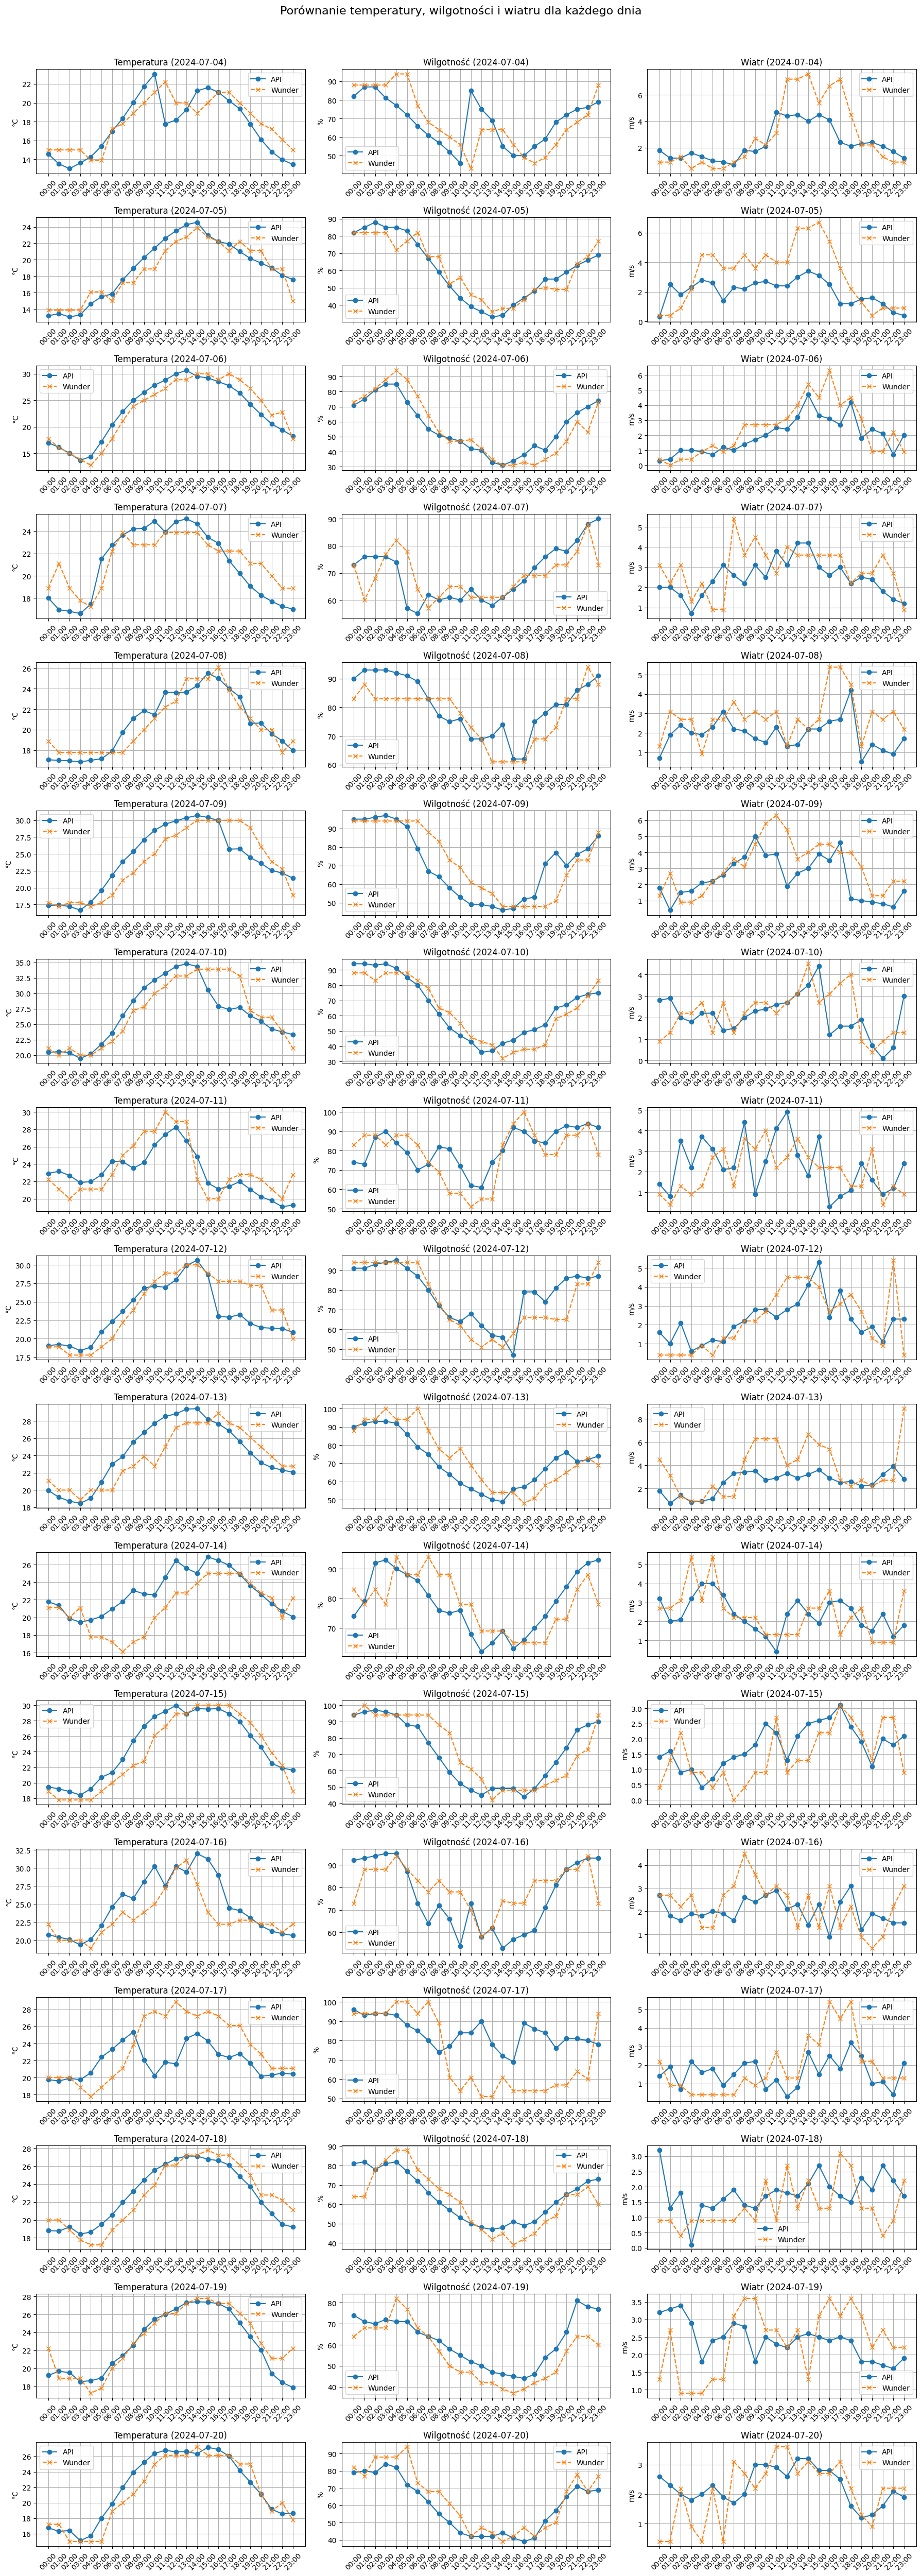

In [28]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Konwersja kolumny date na datę bez godziny (dla grupowania po dniu)
merged_df['day'] = merged_df['date'].dt.date

# Liczba unikalnych dni w danych
unique_days = sorted(merged_df['day'].unique())
num_days = len(unique_days)

# Tworzymy siatkę wykresów: num_days wierszy × 3 kolumny (temp, wilgotność, wiatr)
fig, axes = plt.subplots(nrows=num_days, ncols=3, figsize=(18, 3 * num_days))
fig.suptitle("Porównanie temperatury, wilgotności i wiatru dla każdego dnia", fontsize=16)

# Iteracja po dniach
for i, day in enumerate(unique_days):
    day_data = merged_df[merged_df['day'] == day]  # Filtrujemy dane dla danego dnia
    
    # Oś X to czas (bez daty)
    time_labels = day_data['date'].dt.strftime('%H:%M')
    time_ticks = range(len(time_labels))  # Indeksy dla osi X

    # Wykres temperatury
    ax_temp = axes[i, 0] if num_days > 1 else axes[0]
    ax_temp.plot(time_ticks, day_data['temperature_2m_api'], label="API", marker="o", linestyle="-")
    ax_temp.plot(time_ticks, day_data['temperature_2m_wunder'], label="Wunder", marker="x", linestyle="--")
    ax_temp.set_title(f"Temperatura ({day})")
    ax_temp.set_ylabel("°C")
    ax_temp.set_xticks(time_ticks)  # Najpierw ustaw ticki
    ax_temp.set_xticklabels(time_labels, rotation=45)  # Potem etykiety
    ax_temp.legend()
    ax_temp.grid()

    # Wykres wilgotności
    ax_humidity = axes[i, 1] if num_days > 1 else axes[1]
    ax_humidity.plot(time_ticks, day_data['relative_humidity_2m_api'], label="API", marker="o", linestyle="-")
    ax_humidity.plot(time_ticks, day_data['relative_humidity_2m_wunder'], label="Wunder", marker="x", linestyle="--")
    ax_humidity.set_title(f"Wilgotność ({day})")
    ax_humidity.set_ylabel("%")
    ax_humidity.set_xticks(time_ticks)
    ax_humidity.set_xticklabels(time_labels, rotation=45)
    ax_humidity.legend()
    ax_humidity.grid()

    # Wykres prędkości wiatru
    ax_wind = axes[i, 2] if num_days > 1 else axes[2]
    ax_wind.plot(time_ticks, day_data['wind_speed_10m_api'], label="API", marker="o", linestyle="-")
    ax_wind.plot(time_ticks, day_data['wind_speed_10m_wunder'], label="Wunder", marker="x", linestyle="--")
    ax_wind.set_title(f"Wiatr ({day})")
    ax_wind.set_ylabel("m/s")
    ax_wind.set_xticks(time_ticks)
    ax_wind.set_xticklabels(time_labels, rotation=45)
    ax_wind.legend()
    ax_wind.grid()

# Dopasowanie układu i wyświetlenie
plt.tight_layout(rect=[0, 0, 1, 0.97])  # Dopasowanie układu, aby nie nachodziło na tytuł
plt.show()
